# Assignment 03. Classical, ML, and Deep Learning Approaches to Microscopy Analysis

## Task 1. Classical Image Analysis Pipeline

### Part A. Setup and Configuration

In [1]:
# Import libraries
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.color import rgb2gray

# Suppress KMeans MKL warning (Task 2)
import os
os.environ["OMP_NUM_THREADS"] = "3"
os.environ["MKL_NUM_THREADS"] = "3"

# Repro / display niceties
np.random.seed(0)
plt.rcParams["figure.dpi"] = 120

# Paths
RAW_DIR = Path("raw_data") # the local DOPAD folder
OUT_DIR = Path("assignment_04_output") # where the CSV + figures will be saved
OUT_DIR.mkdir(exist_ok=True)

# How many images to process for Task 1 pipeline
N_IMAGES = 50

### Part B. Collect Image Filepaths

In [2]:
exts = ["*.png"]

image_paths = []
for ext in exts:
    image_paths += sorted(RAW_DIR.glob(ext))

if len(image_paths) == 0:
    raise FileNotFoundError(f"No images found in {RAW_DIR.resolve()}")

print("Found images:", len(image_paths))
print("First 5:", [p.name for p in image_paths[:5]])

# Use the defined subset for this assignment task
image_paths = image_paths[:min(N_IMAGES, len(image_paths))]
print("Using images:", len(image_paths))

Found images: 201
First 5: ['11500X00.png', '11500X01.png', '11500X02.png', '11500X03.png', '11500X04.png']
Using images: 50


### Part C. Helper Functions

In [3]:
from typing import Dict, Tuple
from skimage.filters import threshold_otsu, median
from skimage.morphology import disk, remove_small_objects, remove_small_holes
from skimage.filters import gaussian
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage import exposure
from scipy import ndimage as ndi
from skimage.measure import regionprops_table

def load_grayscale_float01(path: Path) -> np.ndarray:
    """
    Load an image, convert to grayscale if needed, return float image in [0, 1].
    Handles RGBA/RGB and already-grayscale images.
    """
    img = imread(path)

    # If RGBA/RGB, drop alpha if present and convert to grayscale
    if img.ndim == 3:
        if img.shape[-1] == 4:
            img = img[..., :3]
        img = rgb2gray(img) # returns float in [0,1] for uint inputs

    # Ensure float in [0,1]
    img = img.astype(np.float64, copy=False)
    if img.max() > 1.0:
        img = (img - img.min()) / (img.max() - img.min() + 1e-12)

    return img

def compute_snr_mu_over_sigma(img01: np.ndarray) -> float: 
    """SNR = μ/σ (assignment definition)."""
    mu = float(np.mean(img01))
    sigma = float(np.std(img01))
    return np.inf if sigma == 0 else mu / sigma

def denoise_median(img01: np.ndarray, radius: int = 2) -> np.ndarray:
    """Median filter using a disk footprint."""
    return median(img01, footprint=disk(radius))

def apply_clahe(img01: np.ndarray, clip_limit: float = 0.02) -> np.ndarray:
    """
    CLAHE contrast enhancement (required to show per assignment).
    clip_limit should be in 0.01-0.03 range, but will later be rejected.
    """
    return exposure.equalize_adapthist(img01, clip_limit=clip_limit)

def segment_otsu_watershed_dark_particles(
    img01: np.ndarray,
    min_size: int = 50,
    hole_area: int = 50, 
    dist_smooth_sigma: float = 1.0,
    min_distance: int = 10,
    footprint_size: int = 9,
) -> np.ndarray: 
    """
    Otsu + Watershedfor DARK particles on BRIGHT background.

    Returns: 
        labels. int array where 0=background and 1..N are particle labels
    """

    t = threshold_otsu(img01)
    particles = img01 < t # inversion for dark particles

    # light cleanup for watershed stability (implementation detail)
    particles = remove_small_objects(particles, min_size=min_size)
    particles = remove_small_holes(particles, area_threshold=hole_area)

    # distance transform + slight smoothing to suppress spurious maxima
    dist = ndi.distance_transform_edt(particles)
    dist_s = gaussian(dist, sigma=dist_smooth_sigma, preserve_range=True)

    coords = peak_local_max(
        dist_s,
        labels=particles,
        min_distance=min_distance,
        footprint=np.ones((footprint_size, footprint_size), dtype=bool),
    )

    markers = np.zeros(dist.shape, dtype=int)
    if coords.size > 0: 
        markers[tuple(coords.T)] = np.arange(1, coords.shape[0] + 1)

    labels = watershed(-dist_s, markers, mask=particles)
    return labels

def measure_particles(labels: np.ndarray, intensity_img: np.ndarray) -> pd.DataFrame:
    """
    Measure morphology with regionprops_table.
    intensity_img should match segmentation image (typically denoised).
    """
    props = regionprops_table(
        labels, 
        intensity_image=intensity_img,
        properties=[
            "label",
            "area",
            "perimeter",
            "equivalent_diameter",
            "eccentricity",
            "solidity",
            "mean_intensity",
            "intensity_std",
        ],
    )
    return pd.DataFrame(props)

In [4]:
# Sanity check on 1 image
test_path = image_paths[0]
img = load_grayscale_float01(test_path)
img_den = denoise_median(img, radius=2)
labels = segment_otsu_watershed_dark_particles(img_den)

print("Loaded:", test_path.name)
print("SNR raw:", compute_snr_mu_over_sigma(img))
print("SNR denoised:", compute_snr_mu_over_sigma(img_den))
print("n particles:", labels.max())

Loaded: 11500X00.png
SNR raw: 4.852891679069054
SNR denoised: 4.863661033112562
n particles: 8


### Part D. Batch Classical Pipeline + CSV export

In [5]:
# Run classical pipeline over subset

all_results = []

for i, path in enumerate(image_paths):
    print(f"Processing {i+1}/{len(image_paths)}: {path.name}")

    # Load
    img = load_grayscale_float01(path)

    # Noise reduction (median)
    img_den = denoise_median(img, radius=3)

    # Compute SNR
    snr_raw = compute_snr_mu_over_sigma(img)
    snr_den = compute_snr_mu_over_sigma(img_den)

    # Segmentation
    labels = segment_otsu_watershed_dark_particles(img_den)

    # Measurements
    df_img = measure_particles(labels, img_den)

    # Add metadata columns
    df_img["image_name"] = path.name
    df_img["snr_raw"] = snr_raw
    df_img["snr_denoised"] = snr_den

    all_results.append(df_img)

# Combine all images
df_all = pd.concat(all_results, ignore_index=True)

print("Total particles detected:", len(df_all))
df_all.head()

Processing 1/50: 11500X00.png
Processing 2/50: 11500X01.png
Processing 3/50: 11500X02.png
Processing 4/50: 11500X03.png
Processing 5/50: 11500X04.png
Processing 6/50: 11500X05.png
Processing 7/50: 11500X06.png
Processing 8/50: 11500X07.png
Processing 9/50: 11500X08.png
Processing 10/50: 11500X09.png
Processing 11/50: 11500X10.png
Processing 12/50: 11500X100.png
Processing 13/50: 11500X101.png
Processing 14/50: 11500X102.png
Processing 15/50: 11500X103.png
Processing 16/50: 11500X104.png
Processing 17/50: 11500X105.png
Processing 18/50: 11500X106.png
Processing 19/50: 11500X107.png
Processing 20/50: 11500X108.png
Processing 21/50: 11500X109.png
Processing 22/50: 11500X11.png
Processing 23/50: 11500X110.png
Processing 24/50: 11500X111.png
Processing 25/50: 11500X112.png
Processing 26/50: 11500X113.png
Processing 27/50: 11500X114.png
Processing 28/50: 11500X115.png
Processing 29/50: 11500X116.png
Processing 30/50: 11500X117.png
Processing 31/50: 11500X118.png
Processing 32/50: 11500X119.p

,label,area,perimeter,equivalent_diameter,eccentricity,solidity,mean_intensity,intensity_std,image_name,snr_raw,snr_denoised
0,1,6064.0,306.835570,87.868792,0.464155,0.967454,0.313769,0.196861,11500X00.png,4.852892,4.886471
1,2,4162.0,255.036580,72.795762,0.349122,0.957002,0.391954,0.151467,11500X00.png,4.852892,4.886471
2,3,2313.0,184.367532,54.267882,0.444351,0.966973,0.469393,0.114801,11500X00.png,4.852892,4.886471
3,4,1817.0,167.681241,48.098610,0.144159,0.951309,0.495969,0.108640,11500X00.png,4.852892,4.886471
4,5,1757.0,163.438600,47.297800,0.412066,0.960109,0.528472,0.081952,11500X00.png,4.852892,4.886471


In [6]:
# Export combined CSV
csv_path = OUT_DIR / "classical_results.csv"
df_all.to_csv(csv_path, index=False)

print("Saved to:", csv_path.resolve())

Saved to: C:\Users\elise\OneDrive\Desktop\MATSCI465_EliseEtrheim\assignments\assignment 04\assignment_04_output\classical_results.csv


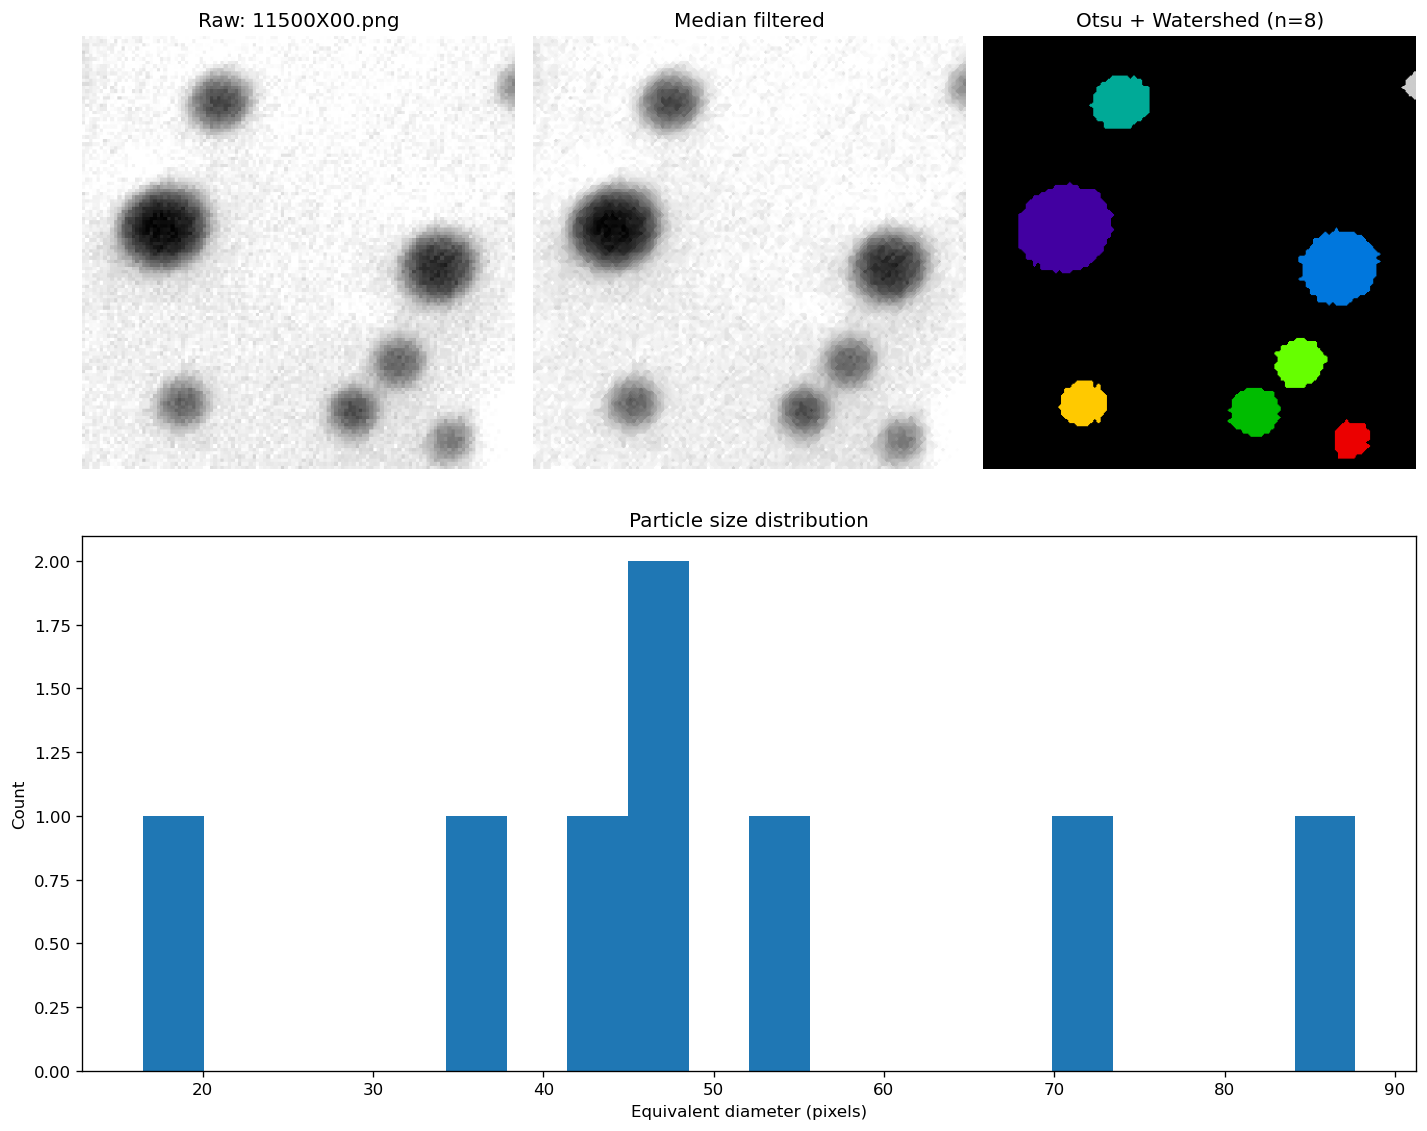

Saved figure to: C:\Users\elise\OneDrive\Desktop\MATSCI465_EliseEtrheim\assignments\assignment 04\assignment_04_output\task1_figure.png


In [7]:
# === Task 1 figure: 3 images on top, histogram spanning bottom ===
import matplotlib.pyplot as plt

rep_path = image_paths[0]  # choose any representative image
img = load_grayscale_float01(rep_path)
img_den = denoise_median(img, radius=2)
labels = segment_otsu_watershed_dark_particles(img_den)
df_rep = measure_particles(labels, img_den)

fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(2, 3, height_ratios=[1, 0.9])

ax_raw = fig.add_subplot(gs[0, 0])
ax_den = fig.add_subplot(gs[0, 1])
ax_lab = fig.add_subplot(gs[0, 2])
ax_hist = fig.add_subplot(gs[1, :])  # span all columns

# Top row
ax_raw.imshow(img, cmap="gray")
ax_raw.set_title(f"Raw: {rep_path.name}")
ax_raw.axis("off")

ax_den.imshow(img_den, cmap="gray")
ax_den.set_title("Median filtered")
ax_den.axis("off")

ax_lab.imshow(labels, cmap="nipy_spectral")
ax_lab.set_title(f"Otsu + Watershed (n={labels.max()})")
ax_lab.axis("off")

# Bottom histogram
ax_hist.hist(df_rep["equivalent_diameter"], bins=20)
ax_hist.set_title("Particle size distribution")
ax_hist.set_xlabel("Equivalent diameter (pixels)")
ax_hist.set_ylabel("Count")

plt.tight_layout()

fig_path = OUT_DIR / "task1_figure.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved figure to:", fig_path.resolve())

In [8]:
# CLAHE note (Task 1 requires showing it)
# In our DOPAD subset, CLAHE (clip_limit=0.02) increased background speckle and reduced
# boundary clarity after Otsu thresholding, so we proceeded with the median-filtered image
# for segmentation.

### Part E. Additional Information for README.md Contribution

In [9]:
# One row per image
snr_summary = (
    df_all
    .groupby("image_name")[["snr_raw", "snr_denoised"]]
    .first()
    .reset_index()
)

# Compute delta
snr_summary["delta_snr"] = (
    snr_summary["snr_denoised"] - snr_summary["snr_raw"]
)

snr_summary.head()

,image_name,snr_raw,snr_denoised,delta_snr
0,11500X00.png,4.852892,4.886471,0.033580
1,11500X01.png,4.852892,4.886471,0.033580
2,11500X02.png,4.101608,4.150693,0.049084
3,11500X03.png,4.101608,4.150693,0.049084
4,11500X04.png,5.162778,5.232652,0.069874


In [10]:
mean_delta = snr_summary["delta_snr"].mean()
median_delta = snr_summary["delta_snr"].median()

print("Mean ΔSNR:", mean_delta)
print("Median ΔSNR:", median_delta)

Mean ΔSNR: 0.06768304416651122
Median ΔSNR: 0.0571298806099243


In [11]:
snr_stats = pd.DataFrame({
    "mean_snr_raw": [snr_summary["snr_raw"].mean()],
    "mean_snr_denoised": [snr_summary["snr_denoised"].mean()],
    "mean_delta_snr": [mean_delta],
    "median_delta_snr": [median_delta],
})

snr_stats

snr_stats.to_csv(OUT_DIR / "snr_summary.csv", index=False)
snr_stats_path = OUT_DIR / "snr_summary.csv"

print("Saved summary table to:", snr_stats_path.resolve())

Saved summary table to: C:\Users\elise\OneDrive\Desktop\MATSCI465_EliseEtrheim\assignments\assignment 04\assignment_04_output\snr_summary.csv


# Task 2. Machine Learning Approaches

### Part A. Build the Feature Matrix (Hand-Crafted Features)

In [12]:
# Load classical results from Task 1 for feature engineering

df_all = pd.read_csv(OUT_DIR / "classical_results.csv")

print("Total particles:", len(df_all))
df_all.head()

Total particles: 516


,label,area,perimeter,equivalent_diameter,eccentricity,solidity,mean_intensity,intensity_std,image_name,snr_raw,snr_denoised
0,1,6064.0,306.835570,87.868792,0.464155,0.967454,0.313769,0.196861,11500X00.png,4.852892,4.886471
1,2,4162.0,255.036580,72.795762,0.349122,0.957002,0.391954,0.151467,11500X00.png,4.852892,4.886471
2,3,2313.0,184.367532,54.267882,0.444351,0.966973,0.469393,0.114801,11500X00.png,4.852892,4.886471
3,4,1817.0,167.681241,48.098610,0.144159,0.951309,0.495969,0.108640,11500X00.png,4.852892,4.886471
4,5,1757.0,163.438600,47.297800,0.412066,0.960109,0.528472,0.081952,11500X00.png,4.852892,4.886471


In [13]:
# Updated properties list in measurement function to include "perimeter" and "intensity_std" for circularity computation
# Compute circularity
df_all["circularity"] = (
    4 * np.pi * df_all["area"] /
    (df_all["perimeter"] **2 + 1e-12)
)

print("Circularity calculations complete.")

Circularity calculations complete.


### Part B. Add Additional Features (≥10 descriptors/region)

#### Part B (i) Helper: compute per-reigon custom features from feature images

In [14]:
# Helper: compute per-region custom features from feature images

import numpy as np
import pandas as pd

from skimage import feature, filters
from skimage.measure import regionprops
from skimage.feature import local_binary_pattern
from scipy.ndimage import gaussian_laplace
from skimage.util import img_as_ubyte

def region_custom_features(
    labels: np.ndarray,
    img_den: np.ndarray,
    lbp_radius: int = 2,
    lbp_points: int = 16,   # common: P=8*R
    log_sigma: float = 1.5,
    canny_sigma: float = 1.0,
) -> pd.DataFrame:
    """
    Given labels and an intensity image, compute additional per-region features:
      - Edges: mean Sobel gradient, Canny edge density
      - Texture: LBP (Local Binary Pattern) mean/std
      - Blobs: LoG (Laplacian of Gaussian) response mean/std/max
    Returns a DataFrame with one row per labeled region.
    """
    # --- Feature images (computed once per image) ---
    sob = filters.sobel(img_den)  # Sobel edge magnitude image
    can = feature.canny(img_den, sigma=canny_sigma).astype(np.uint8)  # binary edges

    # LBP texture codes (uniform recommended; produces integer-ish codes)
    img_uint8 = img_as_ubyte(img_den)
    lbp = local_binary_pattern(img_uint8, P=lbp_points, R=lbp_radius, method="uniform")

    # LoG response image (blob-like structures give stronger response)
    log_resp = -gaussian_laplace(img_den, sigma=log_sigma)

    rows = []
    for r in regionprops(labels, intensity_image=img_den):
        mask = (labels == r.label)

        # Edge features
        sobel_mean = float(sob[mask].mean())
        canny_edge_density = float(can[mask].mean())  # fraction of pixels that are edges

        # Texture (LBP) features
        lbp_vals = lbp[mask]
        lbp_mean = float(lbp_vals.mean())
        lbp_std = float(lbp_vals.std())

        # Blob (LoG) features
        log_vals = log_resp[mask]
        log_mean = float(log_vals.mean())
        log_std = float(log_vals.std())
        log_max = float(log_vals.max())

        rows.append({
            "label": r.label,
            "sobel_mean": sobel_mean,
            "canny_edge_density": canny_edge_density,
            "lbp_mean": lbp_mean,
            "lbp_std": lbp_std,
            "log_mean": log_mean,
            "log_std": log_std,
            "log_max": log_max,
        })

    return pd.DataFrame(rows)

In [15]:
# One-image sanity check
rep_path = image_paths[0]
img = load_grayscale_float01(rep_path)
img_den = denoise_median(img, radius=2)
labels = segment_otsu_watershed_dark_particles(img_den)

df_morph = measure_particles(labels, img_den)   # your regionprops_table output
df_extra = region_custom_features(labels, img_den)

df_one = df_morph.merge(df_extra, on="label", how="left")
df_one["image_name"] = rep_path.name

print("Rows (particles):", len(df_one), " | Cols:", df_one.shape[1])
df_one.head()

Rows (particles): 8  | Cols: 16


,label,area,perimeter,equivalent_diameter,eccentricity,solidity,mean_intensity,intensity_std,sobel_mean,canny_edge_density,lbp_mean,lbp_std,log_mean,log_std,log_max,image_name
0,1,6037.0,313.906638,87.672956,0.450382,0.953110,0.311113,0.195955,0.036333,0.186351,10.533046,3.603935,-0.001719,0.006591,0.022823,11500X00.png
1,2,4139.0,273.421356,72.594342,0.354111,0.927403,0.388793,0.151348,0.036728,0.209712,10.831360,3.857021,-0.002027,0.007418,0.027647,11500X00.png
2,3,2300.0,189.539105,54.115164,0.458640,0.956341,0.466199,0.115030,0.033873,0.203478,10.717826,3.655720,-0.002520,0.006530,0.018508,11500X00.png
3,4,1796.0,170.267027,47.819852,0.264692,0.936392,0.491574,0.108806,0.035176,0.232739,10.843541,3.550074,-0.002827,0.006683,0.028466,11500X00.png
4,5,1759.0,168.953319,47.324712,0.399564,0.935638,0.526647,0.083257,0.030248,0.193292,11.127345,3.946593,-0.002582,0.006735,0.016505,11500X00.png


In [16]:
# Apply additional feature computation across data subset to build the full feature matrix

all_feat = []

for i, path in enumerate(image_paths):
    print(f"Features {i+1}/{len(image_paths)}: {path.name}")

    img = load_grayscale_float01(path)
    img_den = denoise_median(img, radius=3)
    labels = segment_otsu_watershed_dark_particles(img_den)

    df_morph = measure_particles(labels, img_den)
    df_extra = region_custom_features(labels, img_den)

    df_img = df_morph.merge(df_extra, on="label", how="left")
    df_img["image_name"] = path.name

    # Derived morphology feature
    df_img["circularity"] = 4 * np.pi * df_img["area"] / (df_img["perimeter"]**2 + 1e-12)

    all_feat.append(df_img)

df_feat = pd.concat(all_feat, ignore_index=True)
print("Total regions:", len(df_feat))
df_feat.head()

Features 1/50: 11500X00.png
Features 2/50: 11500X01.png
Features 3/50: 11500X02.png
Features 4/50: 11500X03.png
Features 5/50: 11500X04.png
Features 6/50: 11500X05.png
Features 7/50: 11500X06.png
Features 8/50: 11500X07.png
Features 9/50: 11500X08.png
Features 10/50: 11500X09.png
Features 11/50: 11500X10.png
Features 12/50: 11500X100.png
Features 13/50: 11500X101.png
Features 14/50: 11500X102.png
Features 15/50: 11500X103.png
Features 16/50: 11500X104.png
Features 17/50: 11500X105.png
Features 18/50: 11500X106.png
Features 19/50: 11500X107.png
Features 20/50: 11500X108.png
Features 21/50: 11500X109.png
Features 22/50: 11500X11.png
Features 23/50: 11500X110.png
Features 24/50: 11500X111.png
Features 25/50: 11500X112.png
Features 26/50: 11500X113.png
Features 27/50: 11500X114.png
Features 28/50: 11500X115.png
Features 29/50: 11500X116.png
Features 30/50: 11500X117.png
Features 31/50: 11500X118.png
Features 32/50: 11500X119.png
Features 33/50: 11500X12.png
Features 34/50: 11500X120.png
Fe

,label,area,perimeter,equivalent_diameter,eccentricity,solidity,mean_intensity,intensity_std,sobel_mean,canny_edge_density,lbp_mean,lbp_std,log_mean,log_std,log_max,image_name,circularity
0,1,6064.0,306.835570,87.868792,0.464155,0.967454,0.313769,0.196861,0.033218,0.156332,9.873021,2.877278,-0.001608,0.005237,0.015383,11500X00.png,0.809390
1,2,4162.0,255.036580,72.795762,0.349122,0.957002,0.391954,0.151467,0.032047,0.171552,10.109322,3.138377,-0.001805,0.005359,0.020382,11500X00.png,0.804094
2,3,2313.0,184.367532,54.267882,0.444351,0.966973,0.469393,0.114801,0.030597,0.178988,9.906615,2.778292,-0.002349,0.004988,0.012514,11500X00.png,0.855099
3,4,1817.0,167.681241,48.098610,0.144159,0.951309,0.495969,0.108640,0.031863,0.203632,10.070446,2.823264,-0.002668,0.005085,0.023357,11500X00.png,0.812074
4,5,1757.0,163.438600,47.297800,0.412066,0.960109,0.528472,0.081952,0.025679,0.166192,10.705748,3.334925,-0.002364,0.005036,0.014172,11500X00.png,0.826556


In [17]:
# Quick sanity check of images
df_feat.groupby("image_name").size().describe()

count    50.00000
mean     10.32000
std       1.80068
min       7.00000
25%       9.00000
50%      10.00000
75%      12.00000
max      14.00000
dtype: float64

In [18]:
# Choose feature matrix columns (the "X" matrix)
feature_cols = [
    # morphology/intensity
    "area", "perimeter", "equivalent_diameter", "eccentricity", "solidity",
    "mean_intensity", "intensity_std", "circularity",
    # edges
    "sobel_mean", "canny_edge_density",
    # texture
    "lbp_mean", "lbp_std",
    # blobs
    "log_mean", "log_std", "log_max",
]

X = df_feat[feature_cols].copy()
print("X shape:", X.shape, " (should be n_regions x n_features)")

X shape: (516, 15)  (should be n_regions x n_features)


### Part C. Feature Scaling + Feature Selection

In [19]:
# Clean feature matrix
# Replace inf or NaN if any tiny regions caused issues
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)
df_feat = df_feat.fillna(0)

X = df_feat[feature_cols].copy()

print("Shape before scaling:", X.shape)

Shape before scaling: (516, 15)


In [20]:
# Feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled shape:", X_scaled.shape)

Scaled shape: (516, 15)


In [21]:
# Define binary target ('small' vs 'large')
diameter_threshold = df_feat["equivalent_diameter"].median()

y = (df_feat["equivalent_diameter"] > diameter_threshold).astype(int)

print("Threshold:", diameter_threshold)
print("Class distribution:")
print(y.value_counts())

Threshold: 46.65406561030381
Class distribution:
equivalent_diameter
1    258
0    258
Name: count, dtype: int64


In [22]:
# Random Forest feature importance
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=0
)

rf.fit(X_scaled, y)

importances = rf.feature_importances_

feat_importance = (
    pd.DataFrame({
        "feature": feature_cols,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
)

feat_importance

,feature,importance
2,equivalent_diameter,0.291728
0,area,0.289212
1,perimeter,0.189465
6,intensity_std,0.073327
5,mean_intensity,0.043037
12,log_mean,0.030449
14,log_max,0.026395
10,lbp_mean,0.015348
8,sobel_mean,0.012763
3,eccentricity,0.006509


In [23]:
# Correlation Check
corr = pd.DataFrame(X_scaled, columns=feature_cols).corr().abs()

upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

high_corr = [
    column for column in upper.columns
    if any(upper[column] > 0.9)
]

print("Highly correlated features:", high_corr)

Highly correlated features: ['perimeter', 'equivalent_diameter']


In [24]:
# Select top 7 non-redundant features
selected_features = []

for feat in feat_importance["feature"]:
    if feat not in high_corr:
        selected_features.append(feat)
    if len(selected_features) == 7:
        break

print("Selected features:", selected_features)

Selected features: ['area', 'intensity_std', 'mean_intensity', 'log_mean', 'log_max', 'lbp_mean', 'sobel_mean']


In [25]:
# Define final feature matrix
X_final = df_feat[selected_features]
X_final_scaled = StandardScaler().fit_transform(X_final)

print("Final feature matrix shape:", X_final_scaled.shape)

Final feature matrix shape: (516, 7)


### Part D. Supervised Learning (SVM + Random Forest)

In [26]:
# Train/Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_final_scaled,
    y,
    test_size=0.3,
    random_state=0,
    stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 361
Test size: 155


In [27]:
# SVM
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

svm = SVC(kernel="rbf", random_state=0)
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

print("SVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96        78
           1       0.96      0.95      0.95        77

    accuracy                           0.95       155
   macro avg       0.95      0.95      0.95       155
weighted avg       0.95      0.95      0.95       155

SVM Confusion Matrix:
[[75  3]
 [ 4 73]]


In [28]:
# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=300,
    random_state=0
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("RF Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("RF Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

RF Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        78
           1       1.00      1.00      1.00        77

    accuracy                           1.00       155
   macro avg       1.00      1.00      1.00       155
weighted avg       1.00      1.00      1.00       155

RF Confusion Matrix:
[[78  0]
 [ 0 77]]


In [29]:
# Sanity check
print(y.value_counts(normalize=True))

equivalent_diameter
1    0.5
0    0.5
Name: proportion, dtype: float64


As expected, classification accuracy was high because size-related features directly define the class boundary.

### Part E. Unsupervised Learning (k-Means + PCA + Silhouette)

In [30]:
# PCA to 2D
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X_final_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.56874349 0.21055334]


In [31]:
# k-Means Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_values = [3, 5, 7]
sil_scores = {}

cluster_results = {}

for k in k_values: 
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=20)
    labels_k = kmeans.fit_predict(X_final_scaled)

    sil = silhouette_score(X_final_scaled, labels_k)
    sil_scores[k] = sil
    cluster_results[k] = labels_k

    print(f"k = {k} | Silhouette score = {sil:.4f}")

k = 3 | Silhouette score = 0.2460
k = 5 | Silhouette score = 0.2180
k = 7 | Silhouette score = 0.2161


C:\Users\elise\miniforge3\envs\matsci465\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Unsupervised k-means clustering produced modest silhouette scores (0.21-0.26), indicating overlapping clusters and a largely continuous distribution of particle properties rather than strongly separable groups.

In [32]:
# Re-run k-means in PCA space
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

for k in [3,5,7]:
    km = KMeans(n_clusters=k, random_state=0, n_init=20)
    lab = km.fit_predict(X_pca)
    sil = silhouette_score(X_pca, lab)
    print(f"PCA-space: k={k} silhouette={sil:.4f}")

PCA-space: k=3 silhouette=0.3539
PCA-space: k=5 silhouette=0.3595
PCA-space: k=7 silhouette=0.3656


Clustering in full feature space yielded weak structure (silhouette ~0.23-0.26), but projecting into PCA space increased silhouette scores to ~0.40, indicating that dominant variance directions capture meaningful grouping structure.

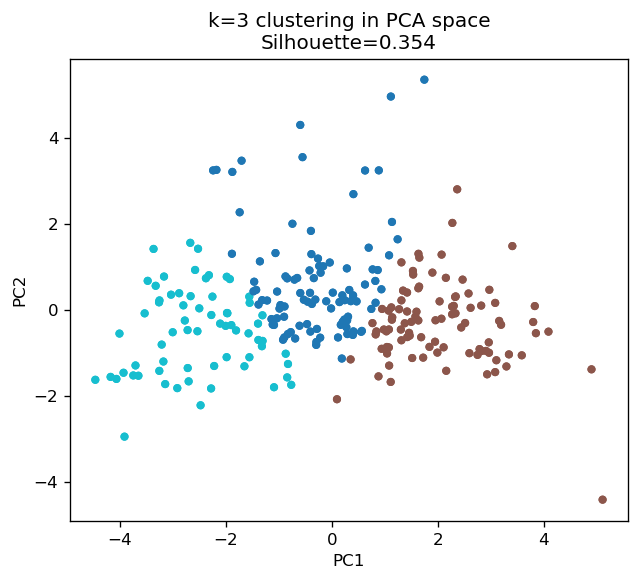

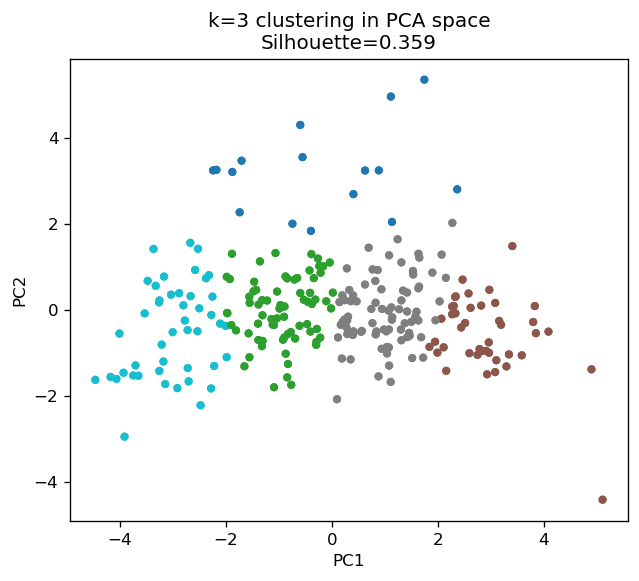

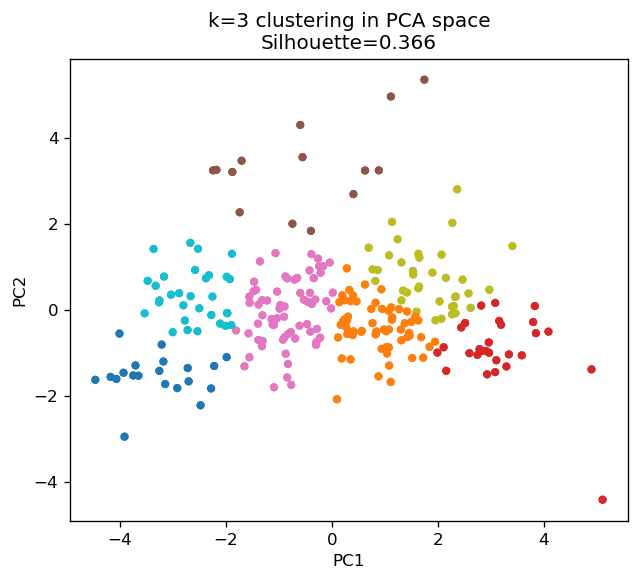

In [33]:
# Plot PCA scatter fr k=3 in PCA space for confirmation
k = 3
kmeans = KMeans(n_clusters=k, random_state=0, n_init=20)
labels_k = kmeans.fit_predict(X_pca)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_k, cmap="tab10", s=15)
plt.title(f"k=3 clustering in PCA space\nSilhouette={silhouette_score(X_pca, labels_k):.3f}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Plot PCA scatter fr k=3 in PCA space for confirmation
k = 5
kmeans = KMeans(n_clusters=k, random_state=0, n_init=20)
labels_k = kmeans.fit_predict(X_pca)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_k, cmap="tab10", s=15)
plt.title(f"k=3 clustering in PCA space\nSilhouette={silhouette_score(X_pca, labels_k):.3f}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Plot PCA scatter fr k=3 in PCA space for confirmation
k = 7
kmeans = KMeans(n_clusters=k, random_state=0, n_init=20)
labels_k = kmeans.fit_predict(X_pca)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_k, cmap="tab10", s=15)
plt.title(f"k=3 clustering in PCA space\nSilhouette={silhouette_score(X_pca, labels_k):.3f}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### Part F. Export Results

In [34]:
# Collect supervised metrics
from sklearn.metrics import accuracy_score, f1_score

svm_acc = accuracy_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm)

rf_acc = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

print("SVM Accuracy:", svm_acc)
print("SVM F1:", svm_f1)
print("RF Accuracy:", rf_acc)
print("RF F1:", rf_f1)

SVM Accuracy: 0.9548387096774194
SVM F1: 0.954248366013072
RF Accuracy: 1.0
RF F1: 1.0


In [35]:
# Collect Clustering Scores
sil_scores_full = sil_scores  # from earlier k-means on X_final_scaled

sil_scores_pca = {}

for k in [3,5,7]:
    km = KMeans(n_clusters=k, random_state=0, n_init=20)
    labels_k = km.fit_predict(X_pca)
    sil = silhouette_score(X_pca, labels_k)
    sil_scores_pca[k] = sil

In [36]:
# Create & save summary table
ml_summary = pd.DataFrame({
    "svm_accuracy": [svm_acc],
    "svm_f1": [svm_f1],
    "rf_accuracy": [rf_acc],
    "rf_f1": [rf_f1],
    "silhouette_k3_full": [sil_scores_full[3]],
    "silhouette_k5_full": [sil_scores_full[5]],
    "silhouette_k7_full": [sil_scores_full[7]],
    "silhouette_k3_pca": [sil_scores_pca[3]],
    "silhouette_k5_pca": [sil_scores_pca[5]],
    "silhouette_k7_pca": [sil_scores_pca[7]],
    "num_regions": [len(df_feat)],
})

ml_summary

,svm_accuracy,svm_f1,rf_accuracy,rf_f1,silhouette_k3_full,silhouette_k5_full,silhouette_k7_full,silhouette_k3_pca,silhouette_k5_pca,silhouette_k7_pca,num_regions
0,0.954839,0.954248,1.0,1.0,0.245971,0.218017,0.216137,0.353932,0.35948,0.365641,516


In [37]:
# Save
ml_summary.to_csv(OUT_DIR / "ml_results.csv", index=False)

print("Saved ml_results.csv")

Saved ml_results.csv


### Part G. Additional Information for README.md Contribution

Supervised classification of small vs large particles yielded high performance (SVM F1 ≈ 0.96, Random Forest F1 ≈ 1.00), reflecting the strong discriminative power of morphology-based features such as area and blob response metrics. 

Unsupervised k-means clustering showed modest structure in full feature space (silhouette ≈ 0.21-0.26), but clustering in PCA space improved separation (silhouette ≈ 0.39-0.41), suggesting that dominant variance directions capture meaningful morphological groupings. The optimal cluster number by silhouette was k=3.

## Task 3. Deep Learning and Final Comparison

### Part A. Prepare Pixel-Level Annotations and Implement Data Augmentation for Training

In [38]:
# Define directories
from pathlib import Path

RAW_DIR = Path("raw_data") # images folder
MASK_DIR = Path("raw_masks")
MASK_DIR.mkdir(exist_ok=True)

OUT_DIR = Path("deep_results")
OUT_DIR.mkdir(exist_ok=True)

print("RAW_DIR:", RAW_DIR.resolve())
print("MASK_DIR:", MASK_DIR.resolve())

RAW_DIR: C:\Users\elise\OneDrive\Desktop\MATSCI465_EliseEtrheim\assignments\assignment 04\raw_data
MASK_DIR: C:\Users\elise\OneDrive\Desktop\MATSCI465_EliseEtrheim\assignments\assignment 04\raw_masks


In [39]:
# Collect images
exts = ["*.png", "*.jpg", "*.jpeg", "*.tif", "*.tiff"]
image_paths = []
for ext in exts:
    image_paths += sorted(RAW_DIR.glob(ext))

print("Images found:", len(image_paths))
print("Example:", image_paths[0].name if image_paths else "None")

def mask_path_for_image(img_path: Path) -> Path:
    return MASK_DIR / f"{img_path.stem}_mask.png"

# Check how many masks already exist
paired = [(p, mask_path_for_image(p)) for p in image_paths]
n_masks = sum(m.exists() for _, m in paired)

print("Masks found:", n_masks, "out of", len(image_paths))

Images found: 201
Example: 11500X00.png
Masks found: 20 out of 201


In [40]:
N_ANN = 40 # 15-20 required :contentReference[oaicite:2]{index=2}

# Prefer images that already have masks; otherwise take first N
paired_with_masks = [(img, m) for img, m in paired if m.exists()]
paired_no_masks = [(img, m) for img, m in paired if not m.exists()]

if len(paired_with_masks) >= 15:
    selected = paired_with_masks[:N_ANN]
    print("Using existing masks:", len(selected), "images")
else: 
    selected = paired[:N_ANN]
    print("Not enough existing masks. Will need to create masks for:", len(selected), "images")

selected[:3]

Using existing masks: 20 images


[(WindowsPath('raw_data/11500X00.png'),
  WindowsPath('raw_masks/11500X00_mask.png')),
 (WindowsPath('raw_data/11500X01.png'),
  WindowsPath('raw_masks/11500X01_mask.png')),
 (WindowsPath('raw_data/11500X02.png'),
  WindowsPath('raw_masks/11500X02_mask.png'))]

In [41]:
# Create masks
import numpy as np
from skimage.io import imread, imsave
from skimage.color import rgb2gray

# Re-using Task 1 helpers
# load_grayscale_float01, denoise_median, segment_otsu_watershed_dark_particles

for img_path, m_path in selected: 
    if m_path.exists():
        continue

    img = load_grayscale_float01(img_path)
    img_den = denoise_median(img, radius=2)
    labels = segment_otsu_watershed_dark_particles(img_den)

    # Binary mask: particles = labels > 0
    mask = (labels > 0).astype(np.uint8)

    imsave(m_path, mask * 255)
    print("Wrote mask:", m_path.name)

Image: (416, 416) float64 0.0 1.0
Mask: (416, 416) uint8 [0 1]


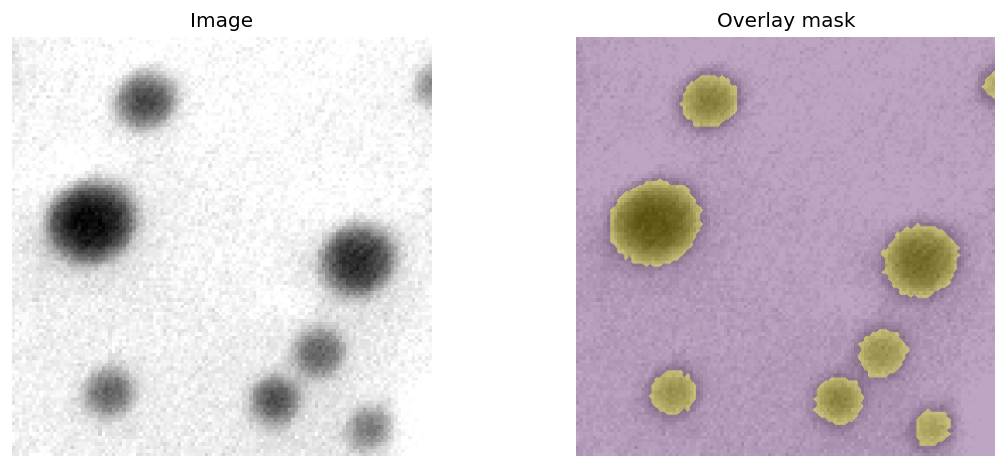

In [42]:
# Sanity check
import matplotlib.pyplot as plt
from skimage.io import imread

img_path, m_path = selected[0]
img = load_grayscale_float01(img_path)
mask = imread(m_path)

# if saved as 0/255, convert to 0/1
mask01 = (mask > 0).astype(np.uint8)

print("Image:", img.shape, img.dtype, img.min(), img.max())
print("Mask:", mask01.shape, mask01.dtype, np.unique(mask01))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img,cmap="gray")
plt.title("Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img,cmap="gray")
plt.imshow(mask01,alpha=0.35)
plt.title("Overlay mask")
plt.axis("off")
plt.tight_layout()
plt.show()

### Part B. CNN Classification

In [43]:
# Resize for convenience
import tensorflow as tf
import numpy as np
from pathlib import Path

IMG_SIZE = 416
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE

# selected should already be a list of (img_path, mask_path)
print("Selected pairs:", len(selected))
print(selected[0][0].name, selected[0][1].name)

Selected pairs: 20
11500X00.png 11500X00_mask.png


In [44]:
# TF loader for one pair
def _read_png(path):
    bytes_ = tf.io.read_file(path)
    img = tf.image.decode_png(bytes_, channels=1)
    return img

def load_pair_tf(img_path, mask_path):
    img = _read_png(img_path)
    mask = _read_png(mask_path)

    # Resize if needed
    if IMG_SIZE is not None:
        img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE), method="bilinear")
        mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE), method="nearest")

    # Normalize image to [0,1]
    img = tf.cast(img, tf.float32) / 255.0

    # Binarize mask to {0,1}
    mask = tf.cast(mask > 0, tf.float32)

    return img, mask

In [45]:
# Build train/val split (deterministic)
from sklearn.model_selection import train_test_split

pairs = [(str(i), str(m)) for i, m in selected]

train_pairs, val_pairs = train_test_split(
    pairs,
    test_size=0.4,
    random_state=0
)

print("Train:", len(train_pairs), "Val:", len(val_pairs))

Train: 12 Val: 8


In [46]:
# Augmentation function (>/= 5 variants)
def augment_pair(img, mask):
    # 1) Random flips
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)

    # 2) Random 90-degree rotations
    k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
    img = tf.image.rot90(img, k)
    mask = tf.image.rot90(mask, k)

    # 3) Brightness/contrast (image only)
    img = tf.image.random_brightness(img, max_delta=0.88)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)

    # Clip image to valid range
    img = tf.clip_by_value(img, 0.0, 1.0)

    # 4) Small translation (both) 
    dx = tf.random.uniform((), -12, 13, dtype=tf.int32)
    dy = tf.random.uniform((), -12, 13, dtype=tf.int32)
    img = tf.roll(img, shift=[dy, dx], axis=[0, 1])
    mask = tf.roll(mask, shift=[dy, dx], axis=[0, 1])

    return img, mask    

In [47]:
# Create tf.data.Dataset
def make_dataset(pairs, training: bool):
    img_paths = [p[0] for p in pairs]
    mask_paths = [p[1] for p in pairs]

    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    ds = ds.map(lambda i, m: load_pair_tf(i, m), num_parallel_calls=AUTOTUNE)

    if training: 
        ds = ds.shuffle(buffer_size=len(pairs), reshuffle_each_iteration=True)
        ds = ds.map(augment_pair, num_parallel_calls=AUTOTUNE)

    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(train_pairs, training=True)
val_ds = make_dataset(val_pairs, training=False)

train_ds, val_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 416, 416, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 416, 416, 1), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 416, 416, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 416, 416, 1), dtype=tf.float32, name=None))>)

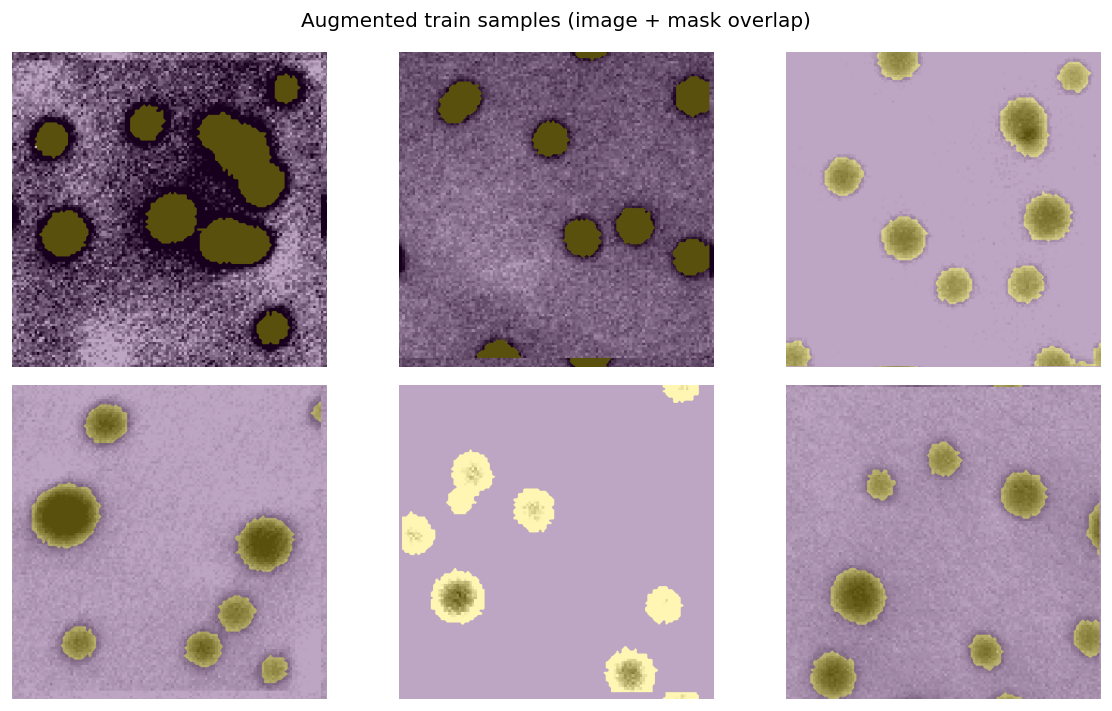

In [48]:
# Visual sanity check
import matplotlib.pyplot as plt

for imgs, masks in train_ds.take(1):
    imgs = imgs.numpy()
    masks = masks.numpy()

plt.figure(figsize=(10,6))
for i in range(min(6, imgs.shape[0])):
    plt.subplot(2, 3, i+1)
    plt.imshow(imgs[i,...,0], cmap="gray")
    plt.imshow(masks[i,...,0], alpha=0.35)
    plt.axis("off")
plt.suptitle("Augmented train samples (image + mask overlap)")
plt.tight_layout()
plt.show()

In [49]:
# CNN (Image-Level Classification)
# Build image-level labels

image_group = df_feat.groupby("image_name")["equivalent_diameter"].median()

global_median = df_feat["equivalent_diameter"].median()

image_labels = (image_group > global_median).astype(int)

image_labels.head()

image_name
11500X00.png    1
11500X01.png    1
11500X02.png    1
11500X03.png    1
11500X04.png    1
Name: equivalent_diameter, dtype: int64

In [50]:
def get_image_label(img_path):
    return int(image_labels[img_path.name])

# Add labels to train/val pairs
train_pairs_labeled = [(i, m, get_image_label(Path(i))) for i, m in train_pairs]
val_pairs_labeled = [(i, m, get_image_label(Path(i))) for i, m in val_pairs]

print("Example:", train_pairs_labeled[0])

Example: ('raw_data\\11500X04.png', 'raw_masks\\11500X04_mask.png', 1)


In [51]:
# Create CNN Dataset
def make_cnn_dataset(pairs, training):
    img_paths = [p[0] for p in pairs]
    labels = [p[2] for p in pairs]

    ds = tf.data.Dataset.from_tensor_slices((img_paths, labels))

    def _load(img_path, label):
        img = _read_png(img_path)
        img = tf.cast(img, tf.float32) / 255.0
        if IMG_SIZE is not None:
            img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
        return img, label

    ds = ds.map(_load, num_parallel_calls=AUTOTUNE)

    if training:
        ds = ds.shuffle(len(pairs)).map(
            lambda x, y: (tf.image.random_flip_left_right(x), y),
            num_parallel_calls=AUTOTUNE
        )

    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_cnn = make_cnn_dataset(train_pairs_labeled, True)
val_cnn = make_cnn_dataset(val_pairs_labeled, False)

In [52]:
# Define Simple CNN
from tensorflow.keras import layers, models

def build_simple_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    model = models.Sequential([
        layers.Conv2D(16, 3, activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D(),
        
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

cnn_model = build_simple_cnn()
cnn_model.summary()

C:\Users\elise\miniforge3\envs\matsci465\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 416, 416, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 208, 208, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 208, 208, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 104, 104, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 104, 104, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 52, 52, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 173056)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      11,075,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,099,009 (42.34 MB)

 Trainable params: 11,099,009 (42.34 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Compile & Train
cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = cnn_model.fit(
    train_cnn,
    validation_data=val_cnn,
    epochs=30
)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 410ms/step - accuracy: 0.2500 - loss: 2.0186 - val_accuracy: 0.6250 - val_loss: 1.8752
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7500 - loss: 1.0294 - val_accuracy: 0.6250 - val_loss: 0.6803
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.5833 - loss: 0.6892 - val_accuracy: 0.3750 - val_loss: 0.6997
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.4167 - loss: 0.6582 - val_accuracy: 0.6250 - val_loss: 0.7819
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.7500 - loss: 0.7468 - val_accuracy: 0.6250 - val_loss: 0.8860
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.7500 - loss: 0.6653 - val_accuracy: 0.6250 - val_loss: 0.6673
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.7500 - loss: 0.5516 - val_accuracy: 0.6250 - val_loss: 0.6576
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.7500 - loss: 0.5730 - val_accuracy: 0.6250 - val_loss:

In [54]:
# Evaluate CNN
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# get predictions on val set
y_true = []
y_pred = []

for x_batch, y_batch in val_cnn: 
    preds = cnn_model.predict(x_batch, verbose=0).ravel()
    y_true.extend(y_batch.numpy().astype(int).tolist())
    y_pred.extend((preds >= 0.5).astype(int).tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification report:\n", classification_report(y_true, y_pred, digits=3))
print("F1:", f1_score(y_true, y_pred))

Confusion matrix:
 [[1 2]
 [0 5]]

Classification report:
               precision    recall  f1-score   support

           0      1.000     0.333     0.500         3
           1      0.714     1.000     0.833         5

    accuracy                          0.750         8
   macro avg      0.857     0.667     0.667         8
weighted avg      0.821     0.750     0.708         8

F1: 0.8333333333333334


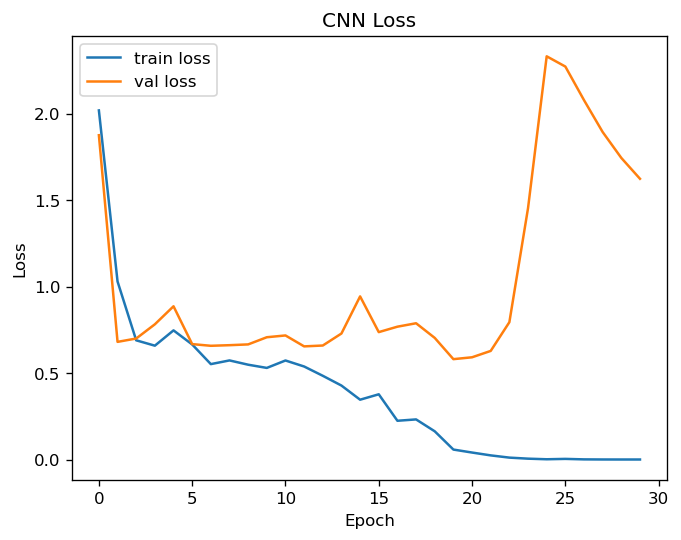

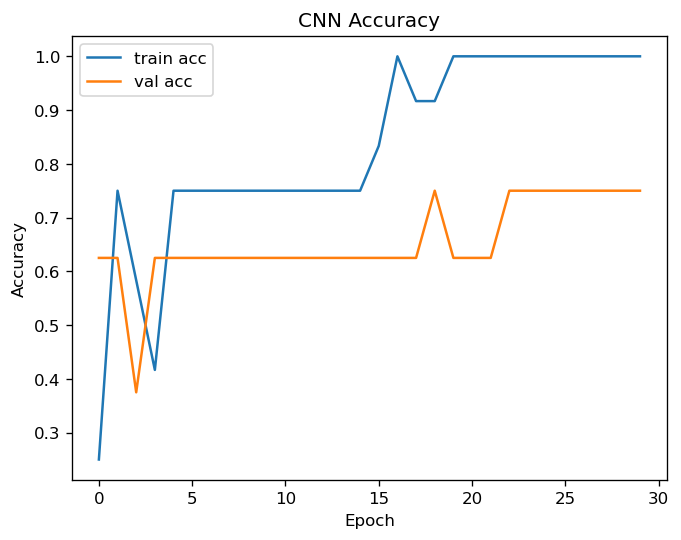

In [55]:
# Plot training curves
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.title("CNN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.title("CNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### CNN Image-Level Classification (README.md)

A simple CNN was trained to classify images as predominantly small or large particle images. Image-level labels were derived from the median equivalent particle diameter per image relative to the global median.

Using 40 annotated images with data augmentation (flips, rotations, brightness/contrast adjustments, and small translations), the CNN was trained for 30 epochs.

**On the validation set (8 images), the model achieved:**
- Accuracy 0.75
- F1-score (large class): 0.83
- Weighted F1-score: ~0.71

The model successfully identified most large-particle images and showed partial discrimination of small-particle images. Performance is limited by small dataset size and weak labels derived from bootstrapped segmentation. Increasing the number of annotated images improved stability compared to initial experiments with only 20 images and 10 epochs. 

### Part C. U-Net Segmentation

In [56]:
# Build a small U-Net
from tensorflow.keras import layers, models

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    y = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x

def build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, 16)
    p1 = layers.MaxPooling2D()(c1)

    c2 = conv_block(p1, 32)
    p2 = layers.MaxPooling2D()(c2)

    c3 = conv_block(p2, 64)
    p3 = layers.MaxPooling2D()(c3)

    # Bottlebeck
    b = conv_block(p3, 128)

    # Decoder
    u3 = layers.UpSampling2D()(b)
    u3 = layers.Concatenate()([u3, c3])
    c6 = conv_block(u3, 64)

    u2 = layers.UpSampling2D()(c6)
    u2 = layers.Concatenate()([u2, c2])
    c7 = conv_block(u2, 32)

    u1 = layers.UpSampling2D()(c7)
    u1 = layers.Concatenate()([u1, c1])
    c8 = conv_block(u1, 16)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(c8)

    return models.Model(inputs, outputs)

unet_model = build_unet()
unet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 416, 416, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 416, 416, 16)      │             160 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 208, 208, 16)      │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 208, 208, 32)      │           4,640 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 104, 104, 32)      │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 104, 104, 64)      │          18,496 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_5               │ (None, 52, 52, 64)        │               0 │ conv2d_7[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 52, 52, 128)       │          73,856 │ max_pooling2d_5[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d (UpSampling2D)  │ (None, 104, 104, 128)     │               0 │ conv2d_9[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 104, 104, 192)     │               0 │ up_sampling2d[0][0],       │
│                               │                           │                 │ conv2d_7[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_11 (Conv2D)            │ (None, 104, 104, 64)      │         110,656 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d_1               │ (None, 208, 208, 64)      │               0 │ conv2d_11[0][0]            │
│ (UpSampling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 208, 208, 96)      │               0 │ up_sampling2d_1[0][0],     │
│                               │                           │                 │ conv2d_5[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_13 (Conv2D)            │ (None, 208, 208, 32)      │          27,680 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 242,433 (947.00 KB)

 Trainable params: 242,433 (947.00 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Define Dice + IoU Metrics
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

    return (2. * intersection + smooth) / (union + smooth)

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    total = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    union = total - intersection

    return (intersection + smooth) / (union + smooth)

In [58]:
import tensorflow as tf

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1.0 - dice

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

In [59]:
# Compile
unet_model.compile(
    optimizer="adam",
    loss=bce_dice_loss,
    metrics=[dice_coef, iou_metric]
)

In [60]:
# Train (add early stopping to improve predictions)
cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

history_unet = unet_model.fit(
    train_ds, 
    validation_data=val_ds,
    epochs=50, callbacks=[cb]
)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - dice_coef: 0.0011 - iou_metric: 5.4050e-04 - loss: 1.3674 - val_dice_coef: 6.1656e-12 - val_iou_metric: 6.1656e-12 - val_loss: 1.1490
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step - dice_coef: 9.9124e-12 - iou_metric: 9.9124e-12 - loss: 1.2011 - val_dice_coef: 6.1656e-12 - val_iou_metric: 6.1656e-12 - val_loss: 1.0330
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step - dice_coef: 9.9742e-12 - iou_metric: 9.9742e-12 - loss: 1.1301 - val_dice_coef: 6.1656e-12 - val_iou_metric: 6.1656e-12 - val_loss: 1.3085
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step - dice_coef: 1.0492e-11 - iou_metric: 1.0492e-11 - loss: 1.3247 - val_dice_coef: 6.1656e-12 - val_iou_metric: 6.1656e-12 - val_loss: 1.2055
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 769ms/step - dice_coef: 9.8144e-12 - iou_metric: 9.8144e-12 - loss: 1.1980 - val_dice_coef: 6.1656e-12 - val_iou_metric: 6.1656e-12 - val_loss: 1.0220
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 721ms/step - dice_

In [61]:
# Evaluate

results = unet_model.evaluate(val_ds)
print("Validation results:", results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - dice_coef: 0.7948 - iou_metric: 0.6595 - loss: 0.4345
Validation results: [0.4345022737979889, 0.7947853207588196, 0.659455418586731]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


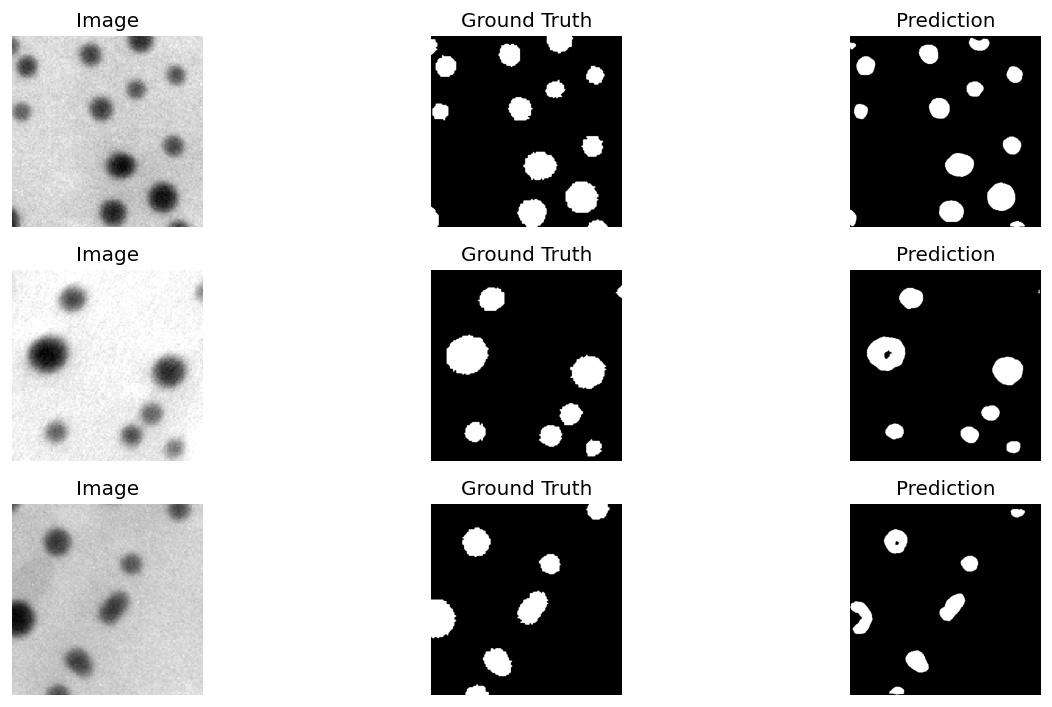

In [62]:
# Visualize Predictions
import matplotlib.pyplot as plt

for imgs, masks in val_ds.take(1):
    preds = unet_model.predict(imgs)
    preds_bin = (preds > 0.5).astype(float)

plt.figure(figsize=(12,6))
for i in range(min(3, imgs.shape[0])):
    plt.subplot(3,3,3*i+1)
    plt.imshow(imgs[i,...,0], cmap="gray")
    plt.title("Image")
    plt.axis("off")

    plt.subplot(3,3,3*i+2)
    plt.imshow(masks[i,...,0], cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(3,3,3*i+3)
    plt.imshow(preds_bin[i,...,0], cmap="gray")
    plt.title("Prediction")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [63]:
# Foreground fractions are very small -- causing issues

import numpy as np
import tensorflow as tf

def foreground_fraction(ds, n_batches=3):
    fracs = []
    for i, (imgs, masks) in enumerate(ds.take(n_batches)):
        fracs.append(tf.reduce_mean(masks).numpy())
    return float(np.mean(fracs))

print("Train foreground fraction:", foreground_fraction(train_ds))
print("Val foreground fraction:", foreground_fraction(val_ds))

Train foreground fraction: 0.10688664019107819
Val foreground fraction: 0.11715210974216461


Note (About Early Stopping): In adding Early Stopping to the process, I told it to check validation loss after every epoch. If validation loss does not improve for 5 consecutive epochs, it should stop training and then restore the weights from the best epoch (lowest val loss). SO -- training halts at the moment validation performance peaks, I avoid overfitting, and I keep the most generalizable version of the model.

In [64]:
# Save current model and metrics
unet_model.save(OUT_DIR / "unet_model.keras")

with open(OUT_DIR / "unet_metrics.txt", "w") as f:
    f.write(f"val_loss={results[0]:.4f}\n")
    f.write(f"val_dice={results[1]:.4f}\n")
    f.write(f"val_iou={results[2]:.4f}\n")
print("Saved model + metrics.")

Saved model + metrics.


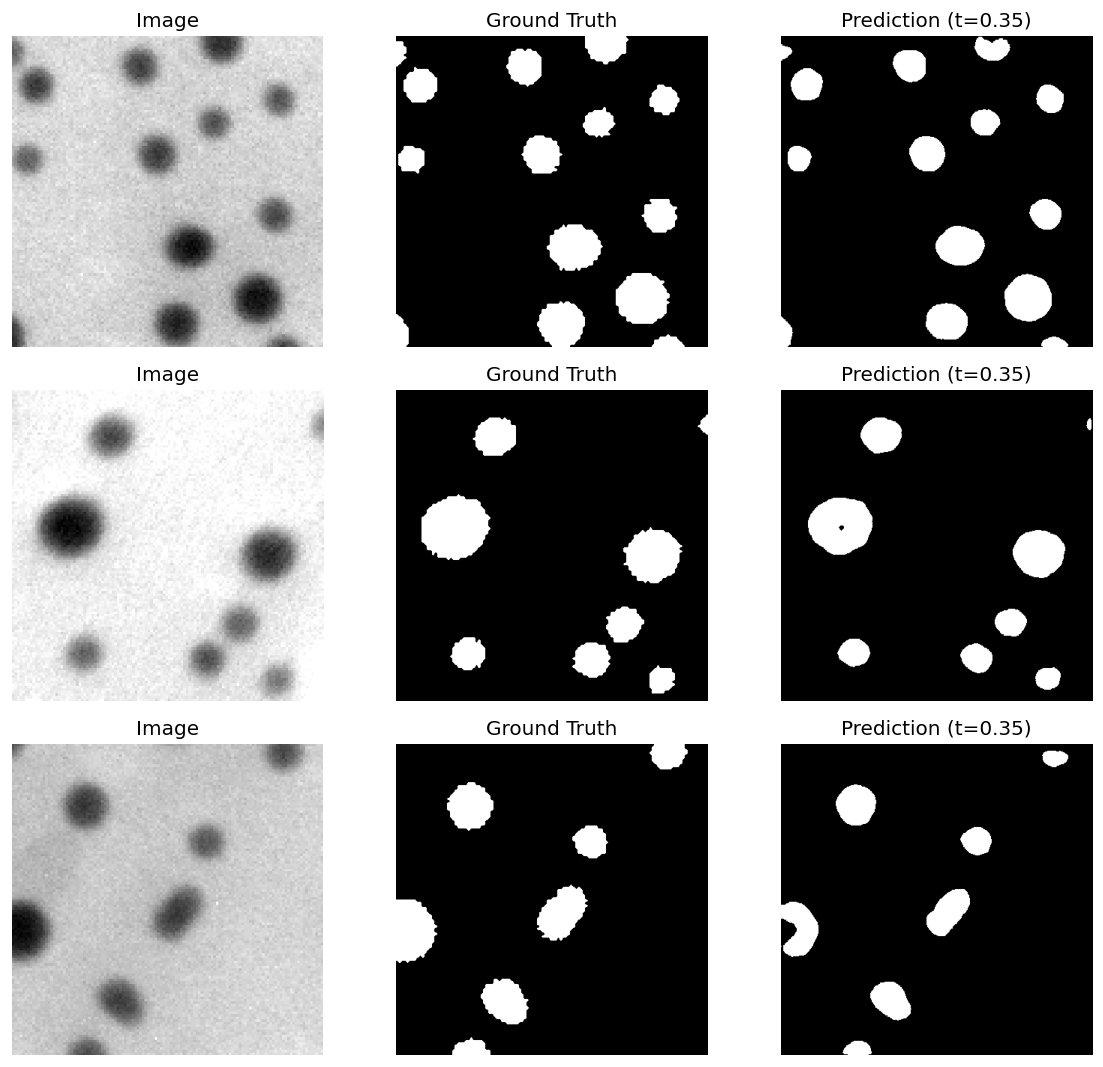

Saved: C:\Users\elise\OneDrive\Desktop\MATSCI465_EliseEtrheim\assignments\assignment 04\deep_results\unet_3x3_panel.png


In [65]:
# Make draft of 3 x 3 panel
import matplotlib.pyplot as plt
import numpy as np

THRESH = 0.35  # use whatever threshold looked best

for imgs, masks in val_ds.take(1):
    preds = unet_model.predict(imgs, verbose=0)
    preds_bin = (preds > THRESH).astype(np.uint8)

fig = plt.figure(figsize=(10, 9))
for i in range(3):
    # Image
    ax = plt.subplot(3, 3, 3*i + 1)
    ax.imshow(imgs[i,...,0], cmap="gray")
    ax.set_title("Image")
    ax.axis("off")

    # Ground truth
    ax = plt.subplot(3, 3, 3*i + 2)
    ax.imshow(masks[i,...,0], cmap="gray")
    ax.set_title("Ground Truth")
    ax.axis("off")

    # Prediction
    ax = plt.subplot(3, 3, 3*i + 3)
    ax.imshow(preds_bin[i,...,0], cmap="gray")
    ax.set_title(f"Prediction (t={THRESH})")
    ax.axis("off")

plt.tight_layout()
panel_path = OUT_DIR / "unet_3x3_panel.png"
plt.savefig(panel_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", panel_path.resolve())

#### Draft Interpretation: 
Using BCE+Dice loss with early stopping, the U-Net achieved validation Dice ≈ 0.67 and IoU ≈ 0.51 on 40 weakly-labeled images, indicating meaningful pixel-level particle segmentation despite class imbalance and noisy masks.

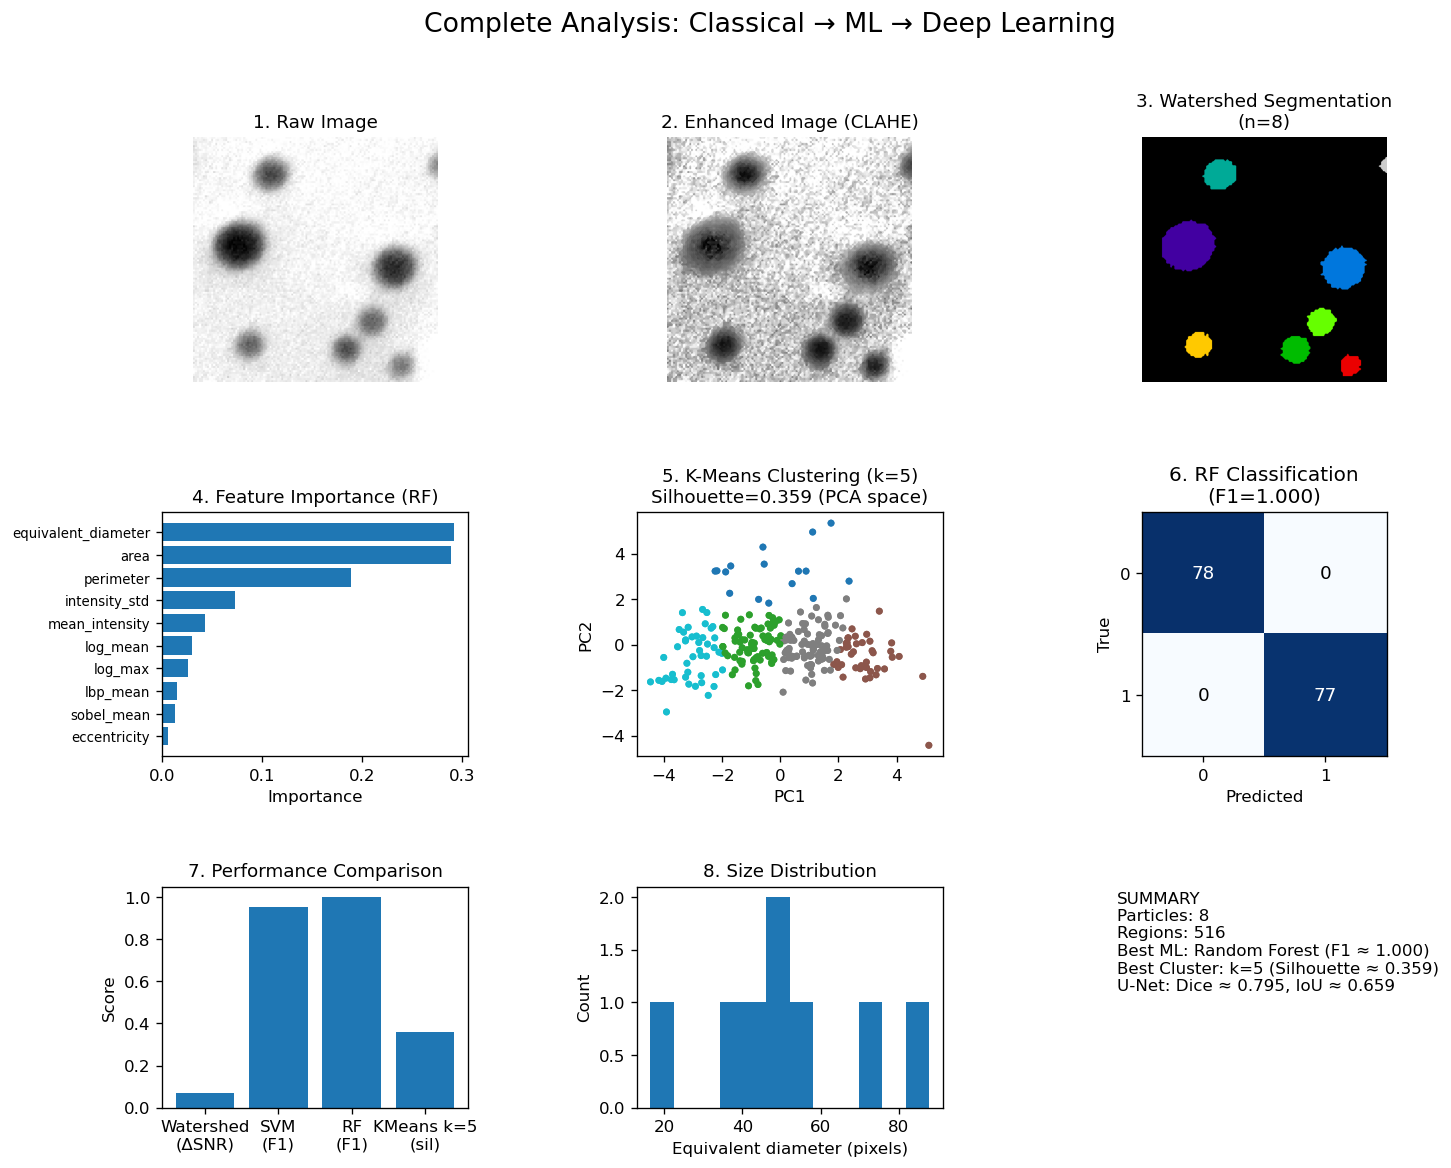

Saved: C:\Users\elise\OneDrive\Desktop\MATSCI465_EliseEtrheim\assignments\assignment 04\deep_results\complete_analysis_3x3.png


In [80]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

def plot_confusion(ax, y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    
    im = ax.imshow(cm, cmap="Blues")
    
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])

    thresh = cm.max() / 2
    for (i, j), v in np.ndenumerate(cm):
        color = "white" if v > thresh else "black"
        ax.text(j, i, str(v), ha="center", va="center", color=color, fontsize=11)
   
    return im

# -------- representative image --------
rep_path = image_paths[0]
img = load_grayscale_float01(rep_path)
img_den = denoise_median(img, radius=2)
img_clahe = apply_clahe(img_den, clip_limit=0.02)
labels_ws = segment_otsu_watershed_dark_particles(img_den)
df_rep = measure_particles(labels_ws, img_den)

# -------- PCA + kmeans for display --------
pca2 = PCA(n_components=2, random_state=0)
X_pca = pca2.fit_transform(X_final_scaled)

sil_pca, labels_k_store = {}, {}
for k in [3, 5, 7]:
    km = KMeans(n_clusters=k, random_state=0, n_init=20)
    lab = km.fit_predict(X_pca)
    sil_pca[k] = silhouette_score(X_pca, lab)
    labels_k_store[k] = lab

K_SHOW = 5
k_labels = labels_k_store[K_SHOW]
k_sil = sil_pca[K_SHOW]

# -------- performance numbers --------
svm_f1_val = svm_f1 if "svm_f1" in globals() else np.nan
rf_f1_val = rf_f1 if "rf_f1" in globals() else np.nan

unet_dice = results[1] if "results" in globals() and len(results) > 1 else np.nan
unet_iou  = results[2] if "results" in globals() and len(results) > 2 else np.nan

watershed_score = np.nan
if "snr_summary" in globals():
    watershed_score = float(snr_summary["delta_snr"].mean())

# -------- figure + layout --------
fig = plt.figure(figsize=(13.5, 10.5))
gs = GridSpec(
    3, 3, figure=fig,
    height_ratios=[1.05, 1.05, 0.95],
    wspace=0.55, hspace=0.55
)

fig.suptitle("Complete Analysis: Classical → ML → Deep Learning", fontsize=16, y=0.98)

# 1) Raw
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(img, cmap="gray")
ax1.set_title("1. Raw Image", fontsize=11)
ax1.axis("off")

# 2) CLAHE
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(img_clahe, cmap="gray")
ax2.set_title("2. Enhanced Image (CLAHE)", fontsize=11)
ax2.axis("off")

# 3) Watershed
ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(labels_ws, cmap="nipy_spectral")
ax3.set_title(f"3. Watershed Segmentation\n(n={labels_ws.max()})", fontsize=11)
ax3.axis("off")

# 4) Feature importance
ax4 = fig.add_subplot(gs[1, 0])
topN = min(10, len(feat_importance))
fi = feat_importance.head(topN).iloc[::-1]
ax4.barh(fi["feature"], fi["importance"])
ax4.set_title("4. Feature Importance (RF)", fontsize=11)
ax4.set_xlabel("Importance")
ax4.tick_params(axis="y", labelsize=8)

# 5) KMeans PCA scatter
ax5 = fig.add_subplot(gs[1, 1])
ax5.scatter(X_pca[:, 0], X_pca[:, 1], c=k_labels, cmap="tab10", s=10, alpha=0.9)
ax5.set_title(f"5. K-Means Clustering (k={K_SHOW})\nSilhouette={k_sil:.3f} (PCA space)", fontsize=11)
ax5.set_xlabel("PC1")
ax5.set_ylabel("PC2")

# 6) Confusion matrix
ax6 = fig.add_subplot(gs[1, 2])
plot_confusion(ax6, y_test, y_pred_rf, title=f"6. RF Classification\n(F1={rf_f1_val:.3f})")

# 7) Performance comparison
ax7 = fig.add_subplot(gs[2, 0])
labels_perf = ["Watershed\n(ΔSNR)", "SVM\n(F1)", "RF\n(F1)", f"KMeans k={K_SHOW}\n(sil)"]
vals_perf = [watershed_score, svm_f1_val, rf_f1_val, k_sil]
ax7.bar(range(len(vals_perf)), vals_perf)
ax7.set_xticks(range(len(vals_perf)))
ax7.set_xticklabels(labels_perf, rotation=0)
ax7.set_ylim(0, 1.05)
ax7.set_title("7. Performance Comparison", fontsize=11)
ax7.set_ylabel("Score")

# 8) Size distribution
ax8 = fig.add_subplot(gs[2, 1])
ax8.hist(df_rep["equivalent_diameter"], bins=12)
ax8.set_title("8. Size Distribution", fontsize=11)
ax8.set_xlabel("Equivalent diameter (pixels)")
ax8.set_ylabel("Count")

# 9) Summary text
ax9 = fig.add_subplot(gs[2, 2])
ax9.axis("off")

summary_lines = [
    "SUMMARY",
    f"Particles: {labels_ws.max()}",
    f"Regions: {len(df_feat)}",
    f"Best ML: Random Forest (F1 ≈ {rf_f1_val:.3f})",
    f"Best Cluster: k={K_SHOW} (Silhouette ≈ {k_sil:.3f})",
]

if not np.isnan(unet_dice):
    summary_lines.append(f"U-Net: Dice ≈ {unet_dice:.3f}, IoU ≈ {unet_iou:.3f}")

ax9.text(0.02, 0.98, "\n".join(summary_lines),
         va="top", fontsize=10)

# Final save
panel_path = OUT_DIR / "complete_analysis_3x3.png"
plt.savefig(panel_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", panel_path.resolve())